In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score
import random
from tqdm import tqdm

torch.manual_seed(0)
random.seed(0)
torch.use_deterministic_algorithms(True)
np.random.seed(0)
torch.random_seed


def generate_synthetic_dataset(
    num_classes,
    num_dimensions,
    total_size,
    test_ratio,
    flip_y,
    random_seed=42
):
    """
    Generates a synthetic dataset with specified number of classes and dimensions.
    The dataset is split into training and testing sets.

    Parameters:
    - num_classes (int): Number of target classes.
    - num_dimensions (int): Number of features/dimensions.
    - total_size (int): Total number of samples.
    - test_ratio (float): Proportion of the dataset to use as the test set.
    - random_seed (int): Random seed for reproducibility.

    Returns:
    - X_train (np.ndarray): Training features.
    - X_test (np.ndarray): Testing features.
    - y_train (np.ndarray): Training labels.
    - y_test (np.ndarray): Testing labels.
    """
    np.random.seed(random_seed)

    # Ensure n_informative is compatible with the number of classes
    n_informative = max(int(np.ceil(np.log2(num_classes))), num_dimensions // 2)
    n_redundant = max(0, num_dimensions // 4)
    n_clusters_per_class = 1  # Ensure compatibility

    # Generate the full dataset
    X, y = make_classification(
        n_samples=total_size,
        n_features=num_dimensions,
        n_informative=n_informative,
        n_redundant=n_redundant,
        n_classes=num_classes,
        n_clusters_per_class=n_clusters_per_class,
        random_state=random_seed,
        flip_y=flip_y
    )

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, random_state=random_seed
    )

    return X_train, X_test, y_train, y_test

def visualize_dataset_2d_3d(X, y, title="Dataset Visualization"):
    """
    Visualizes the dataset in 2D or 3D based on the number of features.

    Parameters:
    - X (np.ndarray): Features of the dataset.
    - y (np.ndarray): Labels of the dataset.
    - title (str): Title of the plot.
    """
    if X.shape[1] == 2:
        plt.figure(figsize=(8, 6))
        for class_label in np.unique(y):
            plt.scatter(X[y == class_label, 0], X[y == class_label, 1], label=f"Class {class_label}")
        plt.title(title)
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.legend()
        plt.show()

    elif X.shape[1] == 3:
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        for class_label in np.unique(y):
            ax.scatter(X[y == class_label, 0], X[y == class_label, 1], X[y == class_label, 2], label=f"Class {class_label}")
        ax.set_title(title)
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")
        ax.set_zlabel("Feature 3")
        ax.legend()
        plt.show()



In [11]:
num_classes = 3
num_dimensions = 3
train_size = 1000
test_size = 500
random_seed = 123
flip_y = 0.10

X_train, X_test, y_train, y_test = generate_synthetic_dataset(
    num_classes, num_dimensions, train_size, test_size, flip_y, random_seed
)

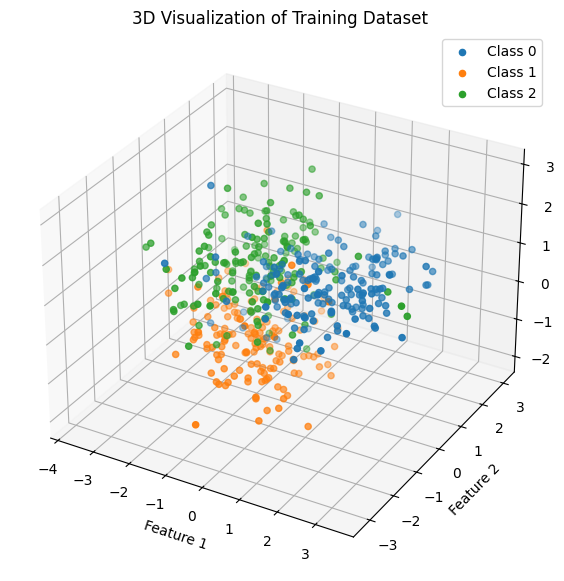

In [12]:
visualize_dataset_2d_3d(X_train,y_train, title="3D Visualization of Training Dataset")

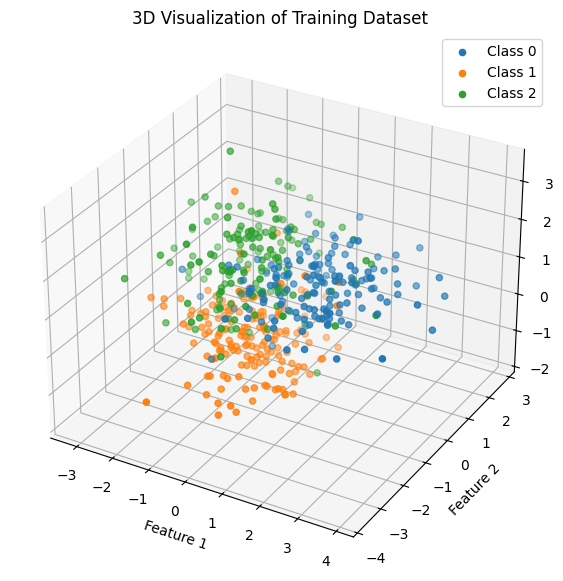

In [13]:
visualize_dataset_2d_3d(X_test,y_test, title="3D Visualization of Training Dataset")

In [22]:
def train_and_evaluate_mlp(X_train, X_test, y_train, y_test, input_dim, hidden_layers, epochs=50, batch_size=32, lr=0.001):
    """
    Train and evaluate an MLP model.
    """
    class MLP(nn.Module):
        def __init__(self, input_dim, hidden_layers, output_dim):
            super(MLP, self).__init__()
            layers = []
            current_dim = input_dim
            for hidden_dim in hidden_layers:
                layers.append(nn.Linear(current_dim, hidden_dim))
                layers.append(nn.ReLU())
                current_dim = hidden_dim
            layers.append(nn.Linear(current_dim, output_dim))
            self.network = nn.Sequential(*layers)

        def forward(self, x):
            return self.network(x)

    # Prepare data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.long)

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    # Model, loss, optimizer
    model = MLP(input_dim, hidden_layers, output_dim=len(set(y_train.numpy())))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    train_loss_history = []
    test_loss_history = []
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        train_loss_history.append(loss.item())

        # Calculate test loss
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test).item()
            test_loss_history.append(test_loss)

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_train_pred = model(X_train).argmax(axis=1).numpy()
        y_test_pred = model(X_test).argmax(axis=1).numpy()

    metrics = {
        "train_accuracy": accuracy_score(y_train.numpy(), y_train_pred),
        "train_precision": precision_score(y_train.numpy(), y_train_pred, average='weighted'),
        "train_recall": recall_score(y_train.numpy(), y_train_pred, average='weighted'),
        "test_accuracy": accuracy_score(y_test.numpy(), y_test_pred),
        "test_precision": precision_score(y_test.numpy(), y_test_pred, average='weighted'),
        "test_recall": recall_score(y_test.numpy(), y_test_pred, average='weighted'),
    }

    return model, y_train_pred, y_test_pred, metrics, train_loss_history, test_loss_history

In [23]:
overfitted_models = []
good_models = []

L_train_good = np.zeros((X_train.shape[0],3))
L_train_overfitted = np.zeros((X_train.shape[0],3))

L_dev_good = np.zeros((X_test.shape[0],3))
L_dev_overfitted = np.zeros((X_test.shape[0],3))

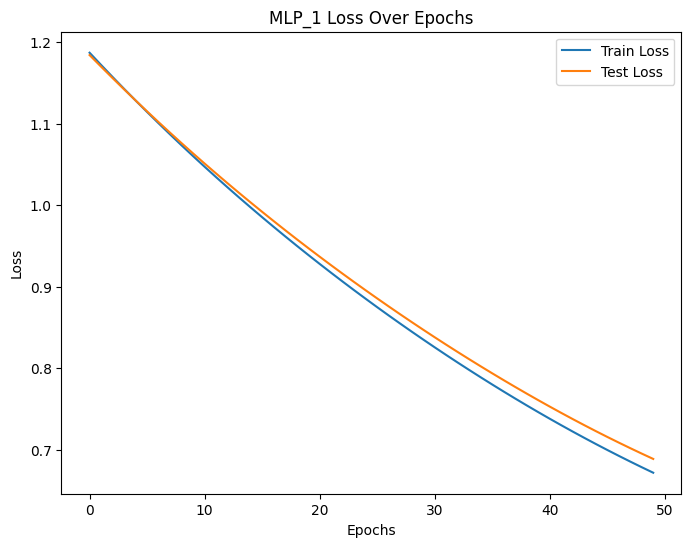

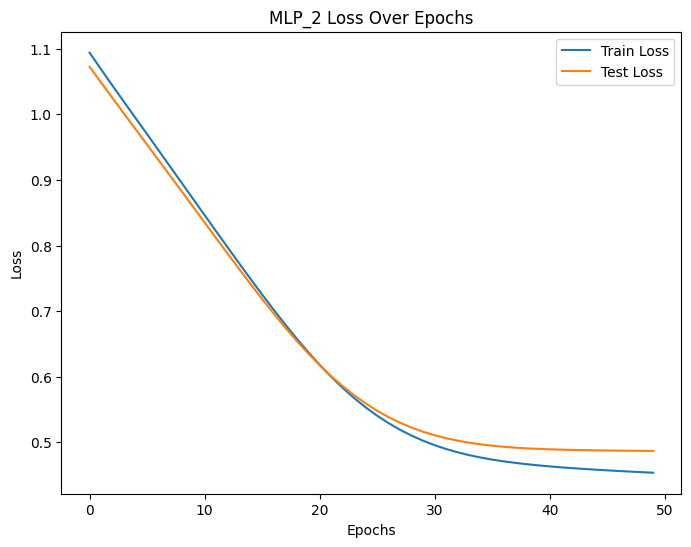

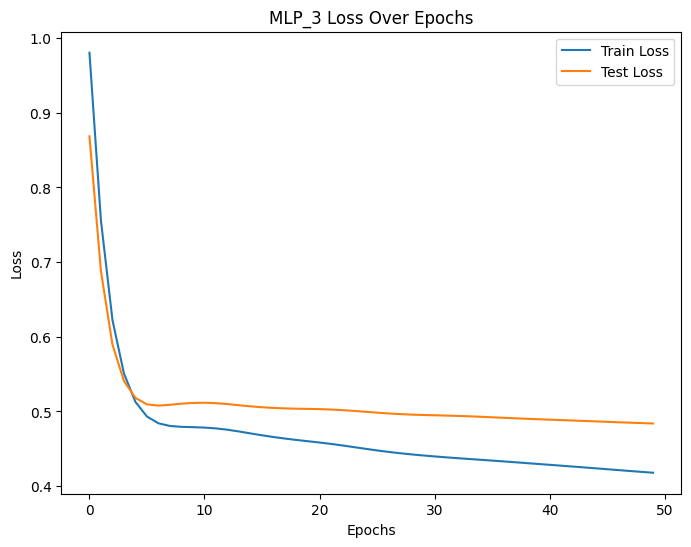

In [29]:


mlps = [
    {"hidden_layers": [32]},
    {"hidden_layers": [64, 32]},
    {"hidden_layers": [1024]},
]

results = []
for i, config in enumerate(mlps):
    model, pred_train_y, pred_test_y, metrics, train_loss_history, test_loss_history = train_and_evaluate_mlp(
        X_train, X_test, y_train, y_test,
        input_dim=num_dimensions,
        hidden_layers=config["hidden_layers"],
        epochs=50,
        batch_size=256,
        lr=0.001
    )
    L_train_good[:,i] = pred_train_y
    L_dev_good[:,i] = pred_test_y

    # L_train_overfitted[:,i] = pred_train_y
    # L_dev_overfitted[:,i] = pred_test_y
    
    good_models.append(model)
    # overfitted_models.append(model)
    results.append({"MLP": f"MLP_{i+1}", **metrics})

    # Plot training and testing loss
    plt.figure(figsize=(8, 6))
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(test_loss_history, label="Test Loss")
    plt.title(f"MLP_{i+1} Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Convert results to DataFrame for better visualization
good_results_df = pd.DataFrame(results)
# overfitted_results_df = pd.DataFrame(results)
# print(results_df)

array([[2., 0., 2.],
       [2., 0., 0.],
       [0., 0., 0.],
       ...,
       [2., 2., 2.],
       [1., 1., 1.],
       [1., 1., 1.]])

Good models statistics:

In [30]:
good_results_df

,MLP,train_accuracy,train_precision,train_recall,test_accuracy,test_precision,test_recall
0,MLP_1,0.834,0.833089,0.834,0.830,0.828724,0.830
1,MLP_2,0.848,0.847124,0.848,0.842,0.841094,0.842
2,MLP_3,0.860,0.859305,0.860,0.848,0.846817,0.848


Bad models statistics:

In [9]:
results_df

,MLP,train_accuracy,train_precision,train_recall,test_accuracy,test_precision,test_recall
0,MLP_1,0.892,0.892142,0.892,0.834,0.834517,0.834
1,MLP_2,0.990,0.990169,0.990,0.770,0.770696,0.770
2,MLP_3,0.996,0.996047,0.996,0.782,0.783165,0.782


# Snorkel 

In [17]:
from snorkel.labeling import labeling_function
import json
import os
import numpy as np
import imageio.v2 as imageio

ModuleNotFoundError: No module named 'snorkel'

In [202]:
@labeling_function()
def Overfitted_1(x):
    # x is a single example, so shape is [num_features]
    X = torch.tensor(x, dtype=torch.float32).unsqueeze(0)  # shape [1, num_features]
    model = overfitted_models[0]
    model.eval()
    with torch.no_grad():
        # model(X) is shape [1, num_classes]
        y_pred = model(X).argmax(dim=1).item()
    return y_pred


@labeling_function()
def Overfitted_2(data):
    X = torch.tensor(data, dtype=torch.float32)
    model = overfitted_models[1]
    model.eval()
    with torch.no_grad():
        y_train_pred = model(X).argmax(axis=0).numpy()

    return y_train_pred


@labeling_function()
def Overfitted_3(data):
    X = torch.tensor(data, dtype=torch.float32)
    model = overfitted_models[2]
    model.eval()
    with torch.no_grad():
        y_train_pred = model(X).argmax(axis=0).numpy()

    return y_train_pred


@labeling_function()
def Good_Model_1(data):
    X = torch.tensor(data, dtype=torch.float32)
    model = good_models[0]
    model.eval()
    with torch.no_grad():
        y_train_pred = model(X).argmax(axis=0).numpy()

    return y_train_pred


@labeling_function()
def Good_Model_2(data):
    X = torch.tensor(data, dtype=torch.float32)
    model = good_models[1]
    model.eval()
    with torch.no_grad():
        y_train_pred = model(X).argmax(axis=0).numpy()

    return y_train_pred


@labeling_function()
def Good_Model_3(data):
    X = torch.tensor(data, dtype=torch.float32)
    model = good_models[2]
    model.eval()
    with torch.no_grad():
        y_train_pred = model(X).argmax(axis=0).numpy()

    return y_train_pred

In [203]:
from snorkel.labeling import LFApplier


# list_of_all_the_models = ['Overfitted_1', 'Overfitted_2', 'Overfitted_3', 'Good_Model_1', 'Good_Model_2', 'Good_Model_3']

lfs = [Overfitted_1, Overfitted_2, Overfitted_3, Good_Model_1, Good_Model_2, Good_Model_3]

# lfs = [Overfitted_1, Overfitted_2, Overfitted_3, Good_Model_1]

applier = LFApplier(lfs)

In [204]:
from snorkel.labeling import LFAnalysis

L_dev = applier.apply(X_test)
L_train = applier.apply(X_train)

500it [00:00, 5628.70it/s]
500it [00:00, 6602.35it/s]


In [208]:
L_train = np.concatenate((L_train_overfitted, L_train_good), axis=1)
L_dev = np.concatenate((L_dev_overfitted, L_dev_good), axis=1) 

In [209]:

LFAnalysis(L_dev, lfs).lf_summary(Y=y_test)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
Overfitted_1,0,"[0.0, 1.0, 2.0]",1.0,1.0,0.23,416,84,0.832
Overfitted_2,1,"[0.0, 1.0, 2.0]",1.0,1.0,0.23,396,104,0.792
Overfitted_3,2,"[0.0, 1.0, 2.0]",1.0,1.0,0.23,393,107,0.786
Good_Model_1,3,"[0.0, 1.0, 2.0]",1.0,1.0,0.23,405,95,0.810
Good_Model_2,4,"[0.0, 1.0, 2.0]",1.0,1.0,0.23,420,80,0.840
Good_Model_3,5,"[0.0, 1.0, 2.0]",1.0,1.0,0.23,423,77,0.846


In [210]:
LFAnalysis(L_train, lfs).lf_summary(Y=y_train)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
Overfitted_1,0,"[0.0, 1.0, 2.0]",1.0,1.0,0.212,447,53,0.894
Overfitted_2,1,"[0.0, 1.0, 2.0]",1.0,1.0,0.212,497,3,0.994
Overfitted_3,2,"[0.0, 1.0, 2.0]",1.0,1.0,0.212,498,2,0.996
Good_Model_1,3,"[0.0, 1.0, 2.0]",1.0,1.0,0.212,407,93,0.814
Good_Model_2,4,"[0.0, 1.0, 2.0]",1.0,1.0,0.212,421,79,0.842
Good_Model_3,5,"[0.0, 1.0, 2.0]",1.0,1.0,0.212,430,70,0.860


In [211]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=3, verbose=True)
label_model.fit(L_train[:,:4], n_epochs=5000, log_freq=500, seed=12)

INFO:root:Computing O...
INFO:root:Estimating \mu...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 4609.31epoch/s]
INFO:root:Finished Training


In [212]:
label_model.get_weights()

array([0.94756095, 0.97410084, 0.96758307, 0.87030729])